In [1]:
%load_ext autoreload
%autoreload 2

import utils
import simplenn as sn
import numpy as np

# Capa de Error Cuadrático

En este ejercicio debés implementar la capa de error `SquaredError`, que permite calcular el error de un lote de ejemplos. 

Las capas de error son diferentes a las capas normales por dos motivos:

1. No solo tienen como entrada la salida de la capa anterior, sino también el valor esperado de la capa anterior (`y` e `y_true`)
2. Para un lote de $n$ ejemplos, su salida es de tamaño $n$. Es decir, indican el valor del error de cada ejemplo con un escalar (número real).

Además, para simplificar, asumimos que las capas de error no tienen parámetros. No obstante, deben poder realizar la operación `backward` de modo de poder propagar hacia atrás el gradiente del error a la red.

La capa de error cuadrático

# Método forward


El método `forward` de la capa `SquaredError` simplemente debe calcular la distancia euclídea al cuadrado entre `y`, los valores producidos por la red, e `y_true`, el valor esperado por la misma.

Por ejemplo, si $y=[2,-2]$ y $y_{true}=[3,3]$, entonces la salida de la capa es:

$$E(y,y_{true})=d_2(y,y_{true})=d_2([2,-2],[3,3])=(2-3)^2+(-2-3)^2 = 1^2+(-5)^2=1+25=26$$

En general, dados dos vectores $a=[a_1,\dots,a_n]$ y $b=[b_1,\dots,b_n]$, la distancia euclídea al cuadrado $d_2$ es:

$$
d_2(a,b)= d_2([a_1,\dots,a_n],[b_1,\dots,b_n]) =(a_1-b_1)^2+\dots+(a_n-b_n)^2
$$

En el caso de un lote de ejemplos, el cálculo es independiente para cada ejemplo. Es importante entonces que la suma de las diferencias al cuadrado se haga por cada ejemplo (fila) y no por cada característica (columna).


In [2]:
y = np.array([[2,-2],
             [-4,4]])
y_true = np.array([[3,3],
             [-5,2]])


layer=sn.SquaredError()
E=np.array([2,29])
utils.check_same(E,layer.forward(y,y_true))

ERROR Arrays are not equal :( (tolerance 1e-12)
Expected:
[ 2 29]
Calculated:
[26  5]


# Método backward

Ahora puedes calcular el error de una red, bien! Esta es la capa final de la red cuando se está entrenando. Por ende el método backward de una capa de error no recibe $\frac{δE}{δy}$; de hecho, debe calcularlo directamente a partir de $y$, $y_{true}$, y la definición del error. Además tampoco hay parámetros.

Por ende, en este caso, la derivada es simple. Solo debemos calcular $\frac{δE}{δy}$, la derivada del error respecto a la salida calculada por la red, $y$.
En este caso $E$ es simétrico respecto de sus entradas, así que llamemosla nuevamente $a$ y $b$, y entonces calculemos la derivada respecto del elemento $i$ de $a$ (la de $b$ sería igual):

$$
\frac{δE(a,b)}{δa_i} = \frac{δ((a_1-b_1)^2+\dots+(a_n-b_n)^2)}{δa_i} \\
= \frac{δ((a_i-b_i)^2)}{δa_i} = 2 (a_i-b_i) \frac{δ((a_i-b_i))}{δa_i} \\
= 2 (a_i-b_i) 1 = 2 (a_i-b_i)
$$
Generalizando para todo el vector $a$, entonces:
$$
\frac{δE(a,b)}{δa} = 2 (a-b)
$$
Donde $a-b$ es una resta entre vectores.

Nuevamente, como este error es por cada ejemplo, entonces los cálculos son independientes en cada fila.

In [3]:
from test import check_gradient

# number of random values of x and δEδy to generate and test gradients
samples = 100
batch_size=2
features_in=3
features_out=5
input_shape=(batch_size,features_in)


layer=sn.SquaredError()
check_gradient.check_gradient_squared_error(layer,input_shape,samples=samples)    


SquaredError_1 layer:
SUCCESS 600 partial derivatives checked, 100 random input samples)


# Error medio o promedio

Si bien la capa SquaredError nos permite calcular los errores de cada ejemplo, para obtener una medida del error respecto a un lote o conjunto de ejemplos, tenemos que calcular el promedio de estos errores. Como este cálculo es independiente de la función de error, 

Nota: Muchas veces a la función de error _de cada ejemplo_ se la llama _loss_, para distinguirla del error promedio

In [4]:
y = np.array([[2,-2],
             [-4,4]])
y_true = np.array([[3,3],
             [-5,2]])


layer=sn.MeanError(sn.SquaredError())
E=15.5
utils.check_same_float(E,layer.forward(y,y_true),title="error")

SUCCESS error is 15.5 :) (tolerance 1e-12)


# Regresión Lineal

Ahora que tenemos todos los elementos, podemos definir y entrenar nuestro primer modelo regresión lineal:

(array([], dtype=int64), array([], dtype=int64))
-2.4120110942417132 3.6855222322816545
1121.8739 63770.42801
Dataset sizes: (1338, 9) (1338, 1)



RMSE 4318.115918430718
MAE 4318.115918430718


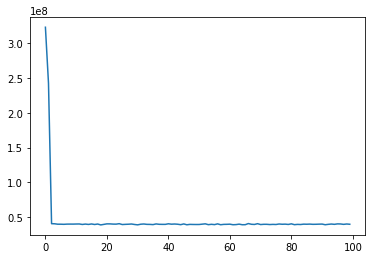

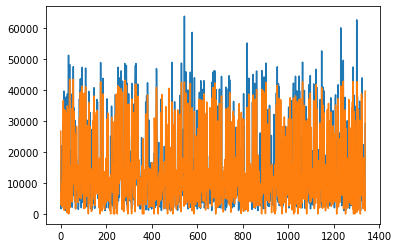

In [124]:
import datasets
from simplenn import metrics

x,y=datasets.load_regression("insurance")
x = (x-x.mean(axis=0))/x.std(axis=0)
n, din = x.shape
n, dout = y.shape
print(np.where(np.isnan(x)))
print(x.min(),x.max())
print(y.min(),y.max())
print("Dataset sizes:", x.shape,y.shape)

model = sn.Sequential([
    sn.Linear(din,dout),
    sn.Bias(dout),
])

model = sn.Sequential([sn.Dense(din,din,activation_name="relu"),
#                 sn.MultiplyConstant(10),
#               sn.ReLU(),
              sn.Dense(din,dout),
                      ])

optimizer = sn.GradientDescent(lr=0.0001)
epochs = 100
batch_size = min(16,max(64,n//16))
batch_size = min(n,batch_size)

error = sn.MeanError(sn.SquaredError())
history = model.fit(x,y,error,epochs,batch_size,optimizer)
y_pred=model.predict(x)
metrics.regression_summary(y,y_pred)
plt.plot(history)
plt.figure()
plt.plot(range(len(y)),y)
plt.plot(range(len(y)),y_pred)

MSE 6.096223937607897
MAE 6.096223937607897


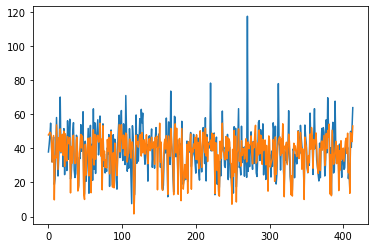

In [119]:
import matplotlib.pyplot as plt
from sklearn import linear_model
model=linear_model.LinearRegression()
model.fit(x,y)
y_pred=model.predict(x)
metrics.regression_summary(y,y_pred)
plt.plot(range(len(y)),y)
plt.plot(range(len(y)),y_pred)
# plt.scatter(y,y_pred)